Load data from google drive

In [ ]:
# mount Google Drive
from google.colab import drive
#drive/MyDrive/Colab/thesis_2
drive.mount("/content/drive/")
path = "/content/drive/My Drive/"

# ------- ------- -------
import sys
sys.path.insert(0,"/content/drive/My Drive/")
#https://www.kaggle.com/code/arnabs007/pretrain-a-bert-language-model-from-scratch

Mounted at /content/drive/


In [ ]:
!pip install torch
!pip install tokenizers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.0 MB/s 
     |████████████████████████████████| 163 kB 83.0 MB/s 


In [ ]:
"""import torch
import tokenizers
import transformers"""

# **Tokenization**


In [ ]:
# Train a tokenizer
import tokenizers

bwpt = tokenizers.BertWordPieceTokenizer()

filepath = path + 'myPreprocessing_PX_Comments.txt'

bwpt.train(
    files=[filepath],
    vocab_size=50000,
    min_frequency=3,
    limit_alphabet=1000
)


In [ ]:
import os
file_tok = './tokenizer'
os.mkdir(file_tok)


In [ ]:
bwpt.save(file_tok + '/config.json')
bwpt.save_model(file_tok )

['./tokenizer/vocab.txt']

In [ ]:
# Load the tokenizer
from transformers import BertTokenizer, LineByLineTextDataset

vocab_file_dir = './tokenizer'

tokenizer = BertTokenizer.from_pretrained(vocab_file_dir)

In [ ]:
# display the tokens
sentence = "النظافه ليست بالشكل المأمول"

encoded_input = tokenizer.tokenize(sentence)
print(encoded_input)
# print(encoded_input['input_ids'])

['النظافه', 'ليست', 'بالشكل', 'المامول']


In [ ]:
#%%time

'''
transformers has a predefined class LineByLineTextDataset()
which reads your text line by line and converts them to tokens
'''

dataset= LineByLineTextDataset(
    tokenizer = tokenizer,
    file_path = path + 'xclean_tnkeeh_myPreprocessing.txt',
    block_size = 512  # maximum sequence length
)

print('No. of lines: ', len(dataset)) # No of lines in your datset

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


No. of lines:  943365


In [ ]:
len(dataset.examples)

943365

# **Defining model**


MLM model

In [ ]:
from transformers import BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling

config = BertConfig(
    vocab_size=50000,
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=12,
    max_position_embeddings=512
)

model = BertForMaskedLM(config)
print('No of parameters: ', model.num_parameters())


data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

No of parameters:  81965648


# **training arguments**



In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./output_dir',
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


# **Training**

In [ ]:
%%time
trainer.train()
trainer.save_model('./model/')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 943365
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 294810
  Number of trainable parameters = 81965648


Step,Training Loss
500,9.306100
1000,8.823400
1500,8.513000
2000,8.294900
2500,8.133600
3000,8.040000
3500,7.927100
4000,7.897200
4500,7.822600
5000,7.744100


Saving model checkpoint to ./output_dir/checkpoint-10000
Configuration saved in ./output_dir/checkpoint-10000/config.json
Model weights saved in ./output_dir/checkpoint-10000/pytorch_model.bin
Saving model checkpoint to ./output_dir/checkpoint-20000
Configuration saved in ./output_dir/checkpoint-20000/config.json
Model weights saved in ./output_dir/checkpoint-20000/pytorch_model.bin
Saving model checkpoint to ./output_dir/checkpoint-30000
Configuration saved in ./output_dir/checkpoint-30000/config.json
Model weights saved in ./output_dir/checkpoint-30000/pytorch_model.bin
Deleting older checkpoint [output_dir/checkpoint-10000] due to args.save_total_limit
Saving model checkpoint to ./output_dir/checkpoint-40000
Configuration saved in ./output_dir/checkpoint-40000/config.json
Model weights saved in ./output_dir/checkpoint-40000/pytorch_model.bin
Deleting older checkpoint [output_dir/checkpoint-20000] due to args.save_total_limit
Saving model checkpoint to ./output_dir/checkpoint-50000
C

CPU times: user 8h 24min 31s, sys: 2min 55s, total: 8h 27min 26s
Wall time: 8h 24min 2s


--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------

# **Finetuning**

In [ ]:
import pandas as pd

## Load dataset

In [ ]:
px_df1 = pd.read_csv(path+'all_subcategories_xcleaned.csv')

px_df1.head(2)

,Unnamed: 0,Journey,Journey#refnumber,comment,xclean,rating,classes,Examination,Patient_Journey,Quality_Care,...,Access,Patient_Disposition,Delays,Referrals,Patient-Staff_Communication,Incorrect_Information,Emotional_Support,Assault_Harassment,Confidentiality,Consent
0,0,PCU,PCU000001,الدكتور لا يتكلم مع المريض ولا يلبس القفازات و...,الدكتور يتكلم المريض يلبس القفازات يدلي باي مع...,Negative,غير مهتم باحتياجات المريض -رعاية طبية دون ال...,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1,1,PCU,PCU000002,الشي الوحيد الذي تضيقت منه في زياره سابقه وليس...,الشي الوحيد تضيقت زياره سابقه وليست اخر زياره ...,Negative,غير مهتم باحتياجات المريض- انتهاك خصوصية المري...,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
print('shape before dropping possible NA rows: ' ,px_df1.shape)
px_df1.drop(inplace=True,columns=['Journey','Journey#refnumber','comment','rating','classes','Unnamed: 0'] ,)
px_df1.dropna(inplace=True, how='any')
print('shape after dropping possible NA rows: ' ,px_df1.shape)


shape before dropping possible NA rows:  (14426, 32)
shape after dropping possible NA rows:  (14423, 26)


In [ ]:
px_df1.head(1)

,xclean,Examination,Patient_Journey,Quality_Care,Treatment,Diagnosis,Medication_Vaccination,Safety_Inceidents,Skills_conducts,Administrative_Policies_procedures,...,Access,Patient_Disposition,Delays,Referrals,Patient-Staff_Communication,Incorrect_Information,Emotional_Support,Assault_Harassment,Confidentiality,Consent
0,الدكتور يتكلم المريض يلبس القفازات يدلي باي مع...,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [ ]:
fifth = int(px_df1.shape[0]/5) * 4 # first 4 fifths for training, the last for testing
px_df1 = px_df1[px_df1['xclean'].notna()]
#px_df1['xclean'].replace('', np.nan, inplace=True)
#px_df2 = px_df1.dropna(subset=['xclean'], inplace=True)
#px_df2.shape

px_df1[:fifth].to_csv('training.csv')
px_df1[fifth:].to_csv('testing.csv')

In [ ]:
cols = px_df1.columns[1:]
print(cols)

Index(['Examination', 'Patient_Journey', 'Quality_Care', 'Treatment',
       'Diagnosis', 'Medication_Vaccination', 'Safety_Inceidents',
       'Skills_conducts', 'Administrative_Policies_procedures', 'Environment',
       'Safety_Security', 'Finance_Billing', 'Staffing', 'Resources',
       'Medical_Records', 'Access', 'Patient_Disposition', 'Delays',
       'Referrals', 'Patient-Staff_Communication', 'Incorrect_Information',
       'Emotional_Support', 'Assault_Harassment', 'Confidentiality',
       'Consent'],
      dtype='object')


## set up the finetuning process

### prepare the dataset

In [ ]:
! pip install datasets

In [ ]:
#model_name = '/content/drive/My Drive/Colab/thesis_2/language_models/PXBert_test_unannotated_33K'
model_name = path + 'arnab_10e/model'
tokenizer_name = path + 'arnab_10e/tokenizer'

In [ ]:
from datasets import load_dataset
dataset = load_dataset('csv' , data_files={'train': 'training.csv', 'test': 'testing.csv'} )

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'xclean', 'Examination', 'Patient_Journey', 'Quality_Care', 'Treatment', 'Diagnosis', 'Medication_Vaccination', 'Safety_Inceidents', 'Skills_conducts', 'Administrative_Policies_procedures', 'Environment', 'Safety_Security', 'Finance_Billing', 'Staffing', 'Resources', 'Medical_Records', 'Access', 'Patient_Disposition', 'Delays', 'Referrals', 'Patient-Staff_Communication', 'Incorrect_Information', 'Emotional_Support', 'Assault_Harassment', 'Confidentiality', 'Consent'],
        num_rows: 11536
    })
    test: Dataset({
        features: ['Unnamed: 0', 'xclean', 'Examination', 'Patient_Journey', 'Quality_Care', 'Treatment', 'Diagnosis', 'Medication_Vaccination', 'Safety_Inceidents', 'Skills_conducts', 'Administrative_Policies_procedures', 'Environment', 'Safety_Security', 'Finance_Billing', 'Staffing', 'Resources', 'Medical_Records', 'Access', 'Patient_Disposition', 'Delays', 'Referrals', 'Patient-Staff_Communication', '

In [ ]:
dataset['train'][0]

{'Unnamed: 0': 0,
 'xclean': 'الدكتور يتكلم المريض يلبس القفازات يدلي باي معلومات رغم وقت الانتظار الطويل يوجد فوضي وعدم ترتيب المواعيد نظافه سييه',
 'Examination': 0,
 'Patient_Journey': 0,
 'Quality_Care': 1,
 'Treatment': 0,
 'Diagnosis': 0,
 'Medication_Vaccination': 0,
 'Safety_Inceidents': 0,
 'Skills_conducts': 0,
 'Administrative_Policies_procedures': 0,
 'Environment': 1,
 'Safety_Security': 0,
 'Finance_Billing': 0,
 'Staffing': 0,
 'Resources': 0,
 'Medical_Records': 0,
 'Access': 1,
 'Patient_Disposition': 0,
 'Delays': 0,
 'Referrals': 0,
 'Patient-Staff_Communication': 1,
 'Incorrect_Information': 0,
 'Emotional_Support': 0,
 'Assault_Harassment': 0,
 'Confidentiality': 0,
 'Consent': 0}

In [ ]:
dataset.remove_columns('Unnamed: 0')

DatasetDict({
    train: Dataset({
        features: ['xclean', 'Examination', 'Patient_Journey', 'Quality_Care', 'Treatment', 'Diagnosis', 'Medication_Vaccination', 'Safety_Inceidents', 'Skills_conducts', 'Administrative_Policies_procedures', 'Environment', 'Safety_Security', 'Finance_Billing', 'Staffing', 'Resources', 'Medical_Records', 'Access', 'Patient_Disposition', 'Delays', 'Referrals', 'Patient-Staff_Communication', 'Incorrect_Information', 'Emotional_Support', 'Assault_Harassment', 'Confidentiality', 'Consent'],
        num_rows: 11536
    })
    test: Dataset({
        features: ['xclean', 'Examination', 'Patient_Journey', 'Quality_Care', 'Treatment', 'Diagnosis', 'Medication_Vaccination', 'Safety_Inceidents', 'Skills_conducts', 'Administrative_Policies_procedures', 'Environment', 'Safety_Security', 'Finance_Billing', 'Staffing', 'Resources', 'Medical_Records', 'Access', 'Patient_Disposition', 'Delays', 'Referrals', 'Patient-Staff_Communication', 'Incorrect_Information', 'Emo

In [ ]:
labels = [label for label in dataset['train'].features.keys() if label not in ['Journey#refnumber', 'cleaned_comment' , 'classes', 'Unnamed: 0','xclean']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [ ]:
labels

['Examination',
 'Patient_Journey',
 'Quality_Care',
 'Treatment',
 'Diagnosis',
 'Medication_Vaccination',
 'Safety_Inceidents',
 'Skills_conducts',
 'Administrative_Policies_procedures',
 'Environment',
 'Safety_Security',
 'Finance_Billing',
 'Staffing',
 'Resources',
 'Medical_Records',
 'Access',
 'Patient_Disposition',
 'Delays',
 'Referrals',
 'Patient-Staff_Communication',
 'Incorrect_Information',
 'Emotional_Support',
 'Assault_Harassment',
 'Confidentiality',
 'Consent']

In [ ]:
len(labels)

25

### tokenize the data.

In [ ]:
#! pip install transformers --upgrade

In [ ]:
from transformers import AutoTokenizer, BertTokenizer
import numpy as np

#tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

In [ ]:

def preprocess_data(examples):
  """try:"""
  # take a batch of texts
  text = examples["xclean"]
  #if text == None:
      #text = '' # avoid the empty comments
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512) # EDIT -------------------------
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
      labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  """except:
  print('Error occured for text: ' , text , ' at indix: ' , examples['Journey#refnumber'])"""
  return encoding

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)


In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 11536
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2887
    })
})

In [ ]:
#encoded_dataset[0]

In [ ]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [ ]:
tokenizer.decode(example['input_ids'])

'[CLS] الدكتور يتكلم المريض يلبس القفازات يدلي باي معلومات رغم وقت الانتظار الطويل يوجد فوضي وعدم ترتيب المواعيد نظافه سييه [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
example['labels']

[0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['Quality_Care', 'Environment', 'Access', 'Patient-Staff_Communication']

In [ ]:
encoded_dataset.set_format("torch")

## Config the model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoModel, BertForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, problem_type="multi_label_classification",
                                                           num_labels=len(labels),id2label=id2label,label2id=label2id)

Some weights of the model checkpoint at /content/drive/My Drive/Colab/thesis_2/arnab_10e/model were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model chec

In [ ]:
batch_size = 16 # * strategy.num_replicas_in_sync #TPU thing
metric_name = "f1_macro"

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir='PX_finetuned2', #-----------
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from transformers import EvalPrediction
#import torch

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=1)
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=1)
    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=1)
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)


    # return as dictionary
    metrics = {'eval_f1_micro': f1_micro_average,
            'eval_f1_macro': f1_macro_average,
            'eval_f1_wighted': f1_weighted_average,
               'eval_roc_auc': roc_auc,
               'eval_accuracy': accuracy,
               'eval_precision': precision,
               'eval_recall' : recall}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
# assume this works without any modifications.
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
encoded_dataset['train']['input_ids'][0]

tensor([   2,  193, 4003,  164, 7462, 3827, 3648,   37, 2103, 2727,  792,  403,
         280, 3152,  233, 4086,  397, 2161,  351, 1468,  419,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [ ]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.6718, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.4182,  0.1906,  0.1998, -0.0262,  0.1060, -0.4752,  0.1018,  0.0988,
         -0.1378,  0.2592, -0.5302, -0.4606,  0.0951,  0.2822, -0.0216, -0.0247,
         -0.0256, -0.0810,  0.0834, -0.1525, -0.1884,  0.0462, -0.3347,  0.3123,
          0.2234]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### Training the customized BERT model

In [ ]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset= encoded_dataset["train"],
    eval_dataset= encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 11536
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3605
  Number of trainable parameters = 81933337


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Wighted,Roc Auc,Accuracy,Precision,Recall
1,0.185900,0.079618,0.708493,0.248942,0.642003,0.812517,0.626948,0.913386,0.234178
2,0.127300,0.070392,0.692452,0.278675,0.651715,0.812618,0.583997,0.849575,0.271558
3,0.097800,0.068154,0.685934,0.309648,0.656799,0.817928,0.568756,0.721772,0.305345
4,0.090000,0.069729,0.685998,0.312850,0.666282,0.835727,0.560097,0.669793,0.320901
5,0.078400,0.070928,0.676159,0.315789,0.662784,0.827967,0.551437,0.636078,0.325409


***** Running Evaluation *****
  Num examples = 2887
  Batch size = 16
Saving model checkpoint to PX_finetuned2/checkpoint-721
Configuration saved in PX_finetuned2/checkpoint-721/config.json
Model weights saved in PX_finetuned2/checkpoint-721/pytorch_model.bin
tokenizer config file saved in PX_finetuned2/checkpoint-721/tokenizer_config.json
Special tokens file saved in PX_finetuned2/checkpoint-721/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2887
  Batch size = 16
Saving model checkpoint to PX_finetuned2/checkpoint-1442
Configuration saved in PX_finetuned2/checkpoint-1442/config.json
Model weights saved in PX_finetuned2/checkpoint-1442/pytorch_model.bin
tokenizer config file saved in PX_finetuned2/checkpoint-1442/tokenizer_config.json
Special tokens file saved in PX_finetuned2/checkpoint-1442/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2887
  Batch size = 16
Saving model checkpoint to PX_finetuned2/checkpoint-2163
Configuration sav

TrainOutput(global_step=3605, training_loss=0.10997242590260076, metrics={'train_runtime': 798.8249, 'train_samples_per_second': 72.206, 'train_steps_per_second': 4.513, 'total_flos': 7643853566361600.0, 'train_loss': 0.10997242590260076, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2887
  Batch size = 16


{'eval_f1_micro': 0.6761593226861651,
 'eval_f1_macro': 0.31578933977912876,
 'eval_f1_wighted': 0.662783759061472,
 'eval_roc_auc': 0.8279672403818117,
 'eval_accuracy': 0.5514374783512297,
 'eval_precision': 0.6360776960118231,
 'eval_recall': 0.32540860260107296,
 'eval_loss': 0.07092835009098053,
 'eval_runtime': 12.3921,
 'eval_samples_per_second': 232.972,
 'eval_steps_per_second': 14.606,
 'epoch': 5.0}

## Find classification report and Confusion matrix

#### Predict:

In [ ]:
testing_set = load_dataset('csv' , data_files={'test': 'testing.csv'} )
testing_set

In [ ]:
testing_set['test']
testing_labels = [label for label in testing_set['test'].features.keys() if label not in ['Journey#refnumber', 'cleaned_comment' , 'classes', 'Unnamed: 0']]


In [ ]:
encoded_testing_set = testing_set.map(preprocess_data, batched=True, remove_columns=dataset['test'].column_names)

In [ ]:
trainer_pred = trainer.predict(encoded_testing_set['test'])

***** Running Prediction *****
  Num examples = 2887
  Batch size = 16


In [ ]:
trainer_pred

PredictionOutput(predictions=array([[-4.379275 , -4.79945  , -1.486343 , ..., -5.0861974, -5.6341724,
        -6.536087 ],
       [-4.270345 , -3.3798876, -4.512876 , ..., -4.3418384, -3.8979924,
        -4.5678124],
       [-3.1566002, -4.1799965,  2.5087142, ..., -3.7455308, -6.1417303,
        -6.575617 ],
       ...,
       [-3.1621642, -5.473138 , -4.081207 , ..., -3.4150841, -4.4314957,
        -6.5485206],
       [-4.620775 , -4.679479 , -3.8299007, ..., -3.2842774, -2.7619631,
        -5.691662 ],
       [-4.461535 , -5.6737366, -4.0782666, ..., -5.5038023, -5.4350505,
        -6.7707887]], dtype=float32), label_ids=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), metrics={'test_loss': 0.07092835009098053, 'test_eval_f1_micro': 0.6761593226861651, 'test_eval_f1_macro': 0.31

In [ ]:
trainer_pred.predictions[1]

array([-4.270345  , -3.3798876 , -4.512876  , -4.093629  , -3.8853452 ,
       -3.5019667 , -3.4584525 , -4.0076795 , -4.14427   , -2.9798176 ,
       -4.4448695 , -4.033309  , -4.5611653 , -3.9152997 ,  0.54741365,
       -2.9987519 , -4.7571836 , -3.8120952 , -3.4229524 , -2.202561  ,
       -2.7662127 , -3.9602778 , -4.3418384 , -3.8979924 , -4.5678124 ],
      dtype=float32)

#### Convert the testing and prediction labels to compatible format:
INTEGER.

In [ ]:
#trainer_pred.predictions
#preds = np.argmax(trainer_pred.predictions, axis=-1)

# now convert the results of prediction into integer rather than float
def convert_preds(y_preds):
  # 1st convert from float to boolean
  y_pred1_bool = (y_preds > 0.5)
  #print(y_pred1_bool[0:2])

  # 2nd match the boolean to integer
  y_pred1_int = []
  for row in y_pred1_bool:
    temp = []
    for j in row:
      if j: # if True
        temp.append(1)
      else: # if False
        temp.append(0)
    y_pred1_int.append(temp)

  #print("first 2 rows:\n" ,y_pred1_int[0:2])
  return y_pred1_int

# y_pred1_int = convert_preds(y_pred1)

In [ ]:
#trainer_pred[1]

# the following, is combining the labels for each row of data in an array:
""" """
test_labels = []
for i in range(0,len(encoded_dataset['test'])):
    test_labels.append(encoded_dataset["test"][i]['labels'].numpy().astype(int)
)

print(test_labels[0:5])

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])]


In [ ]:
#trainer_pred[1]
#type(test_labels)
reshaped_testing_labels = np.array(test_labels)



In [ ]:
reshaped_testing_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_pred1_int = convert_preds(trainer_pred.predictions)

In [ ]:
y_pred1_int[:3]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

#### Print Classification Report, Confusion Matrix, and Plot Confusion Matrix.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix,accuracy_score

print(classification_report(test_labels,y_pred1_int))
print(accuracy_score(test_labels,y_pred1_int))

              precision    recall  f1-score   support

           0       0.67      0.17      0.27        12
           1       0.00      0.00      0.00        10
           2       0.56      0.46      0.50       399
           3       0.00      0.00      0.00        99
           4       0.00      0.00      0.00        17
           5       0.79      0.81      0.80       115
           6       0.00      0.00      0.00        63
           7       0.30      0.19      0.23        16
           8       0.58      0.20      0.30        75
           9       0.91      0.84      0.87      1246
          10       1.00      0.08      0.15        37
          11       0.00      0.00      0.00         7
          12       0.38      0.64      0.48        47
          13       0.55      0.32      0.40       113
          14       0.41      0.39      0.40        23
          15       0.74      0.69      0.72        78
          16       0.00      0.00      0.00         2
          17       0.67    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
cf_bert = multilabel_confusion_matrix(test_labels,y_pred1_int)
#print(cf_bert)

## Plot Confusion Matrix

In [ ]:
tn_cf_bert = cf_bert[:, 0, 0]
tp_cf_bert = cf_bert[:, 1, 1]
fn_cf_bert = cf_bert[:, 1, 0]
fp_cf_bert = cf_bert[:, 0, 1]
print(tn_cf_bert , '\n',tp_cf_bert, '\n', fn_cf_bert ,'\n' , fp_cf_bert)

[2874 2877 2346 2788 2870 2748 2824 2864 2801 1535 2850 2880 2791 2744
 2851 2790 2885 2560 2879 2816 2887 2879 2869 2870 2887] 
 [   2    0  182    0    0   93    0    3   15 1048    3    0   30   36
    9   54    0  178    0    0    0    0    0    0    0] 
 [ 10  10 217  99  17  22  63  13  60 198  34   7  17  77  14  24   2  61
   8   1   0   8   1  16   0] 
 [  1   0 142   0   0  24   0   7  11 106   0   0  49  30  13  19   0  88
   0  70   0   0  17   1   0]


In [ ]:
cols

Index(['Examination', 'Patient_Journey', 'Quality_Care', 'Treatment',
       'Diagnosis', 'Medication_Vaccination', 'Safety_Inceidents',
       'Skills_conducts', 'Administrative_Policies_procedures', 'Environment',
       'Safety_Security', 'Finance_Billing', 'Staffing', 'Resources',
       'Medical_Records', 'Access', 'Patient_Disposition', 'Delays',
       'Referrals', 'Patient-Staff_Communication', 'Incorrect_Information',
       'Emotional_Support', 'Assault_Harassment', 'Confidentiality',
       'Consent'],
      dtype='object')

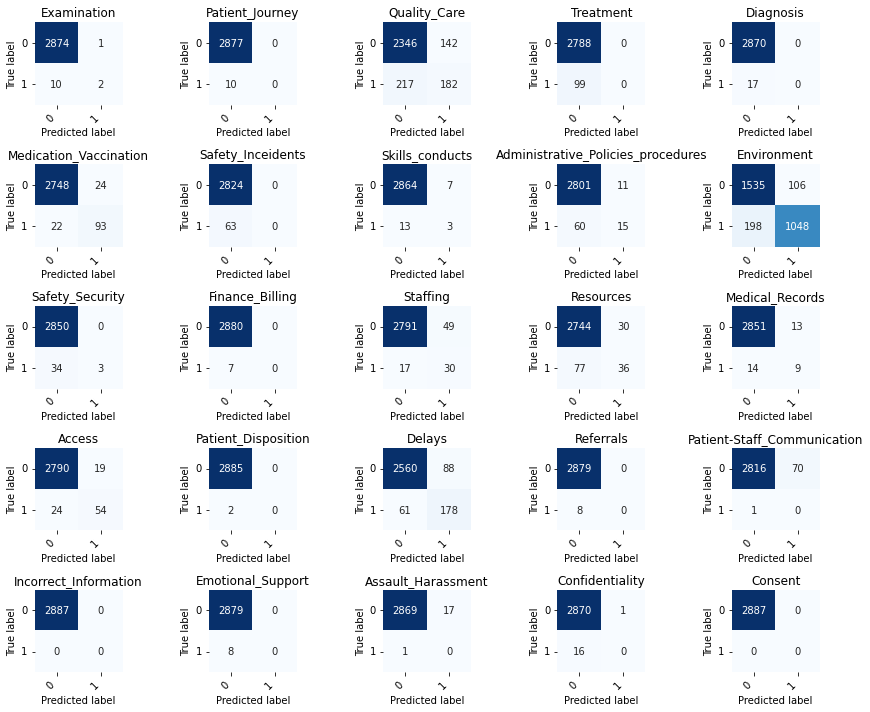

In [ ]:
# plot cf
#sys.path.insert(0,"/content/drive/My Drive/Colab/thesis_2/")
import PlotConfusion
PlotConfusion.print_cf(cf_bert,cols)